In [8]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix, classification_report

from keras.models import model_from_json

# View the Data

Text(0.5, 1.0, 'Negative sample')

<Figure size 432x288 with 0 Axes>

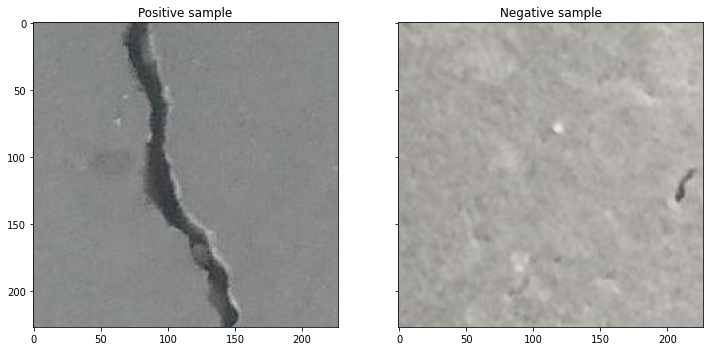

In [9]:
pos_sample = plt.imread('../input/surface-crack-detection/Positive/00001.jpg')
neg_sample = plt.imread('../input/surface-crack-detection/Negative/00001.jpg')
plt.figure()
fig, ax = plt.subplots(1,2, figsize=(12,12), sharey=True)
ax[0].imshow(pos_sample)
ax[0].set_title("Positive sample")
ax[1].imshow(neg_sample)
ax[1].set_title("Negative sample")

In [10]:
pos_dir = Path('../input/surface-crack-detection/Positive')
neg_dir = Path('../input/surface-crack-detection/Negative')

# Creating DataFrames

In [11]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [12]:
pos_df = generate_df(pos_dir, "POSITIVE")
neg_df = generate_df(neg_dir, "NEGATIVE")

all_df = pd.concat([pos_df, neg_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True) #shuffle the data, random_state for reproducibility
all_df

,Filepath,Label
0,../input/surface-crack-detection/Positive/0574...,POSITIVE
1,../input/surface-crack-detection/Positive/1870...,POSITIVE
2,../input/surface-crack-detection/Positive/0967...,POSITIVE
3,../input/surface-crack-detection/Negative/0791...,NEGATIVE
4,../input/surface-crack-detection/Positive/1400...,POSITIVE
...,...,...
39995,../input/surface-crack-detection/Positive/0854...,POSITIVE
39996,../input/surface-crack-detection/Negative/1944...,NEGATIVE
39997,../input/surface-crack-detection/Positive/0977...,POSITIVE
39998,../input/surface-crack-detection/Positive/1504...,POSITIVE


## Split the data

In [13]:
train_df, test_df = train_test_split(
    all_df.sample(6000, random_state=1), #since there is 40000 images in total, we sample only 6000 for speed up the training
    train_size = 0.7, #train set is 70% and the rest is the test set
    shuffle=True,
    random_state=1
)

# Loading Image Data

In [ ]:
#we are using imageDataGenerator for better performance, this will load in the images, train on them and then recycle the memory for us

In [14]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, #pixel values down into a range of between 0 and 1
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [15]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42,
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


# Create Models

In [33]:
basic_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[128,128,3]),
    
    layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
], name='basic_model')

In [32]:
wider_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[128,128,3]),
    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
], name='wider_model')

In [31]:
deeper_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[128,128,3]),
    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
], name='deeper_model')

In [49]:
global_avg_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[128,128,3]),
    
    layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
], name='global_avg_model')

In [29]:
dropout_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[128,128,3]),
    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(4, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
], name='dropout_model')

In [38]:
batch_normal_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[128,128,3]),
    
    layers.BatchNormalization(),
    layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
], name='batch_normal_model')

# Create Functions for the models

In [19]:
def compile_model(model, optimizer='adam'):
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['binary_accuracy'] 
    )
    model.summary()
    
def fit_model(model, train_data, val_data):
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=100,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            )
        ]
    )
    return history

def plot_history(history):
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
    
def save_model(model):
    model_json = model.to_json()
    with open(model.name + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model.name + ".h5")
    print(model.name + " is saved")

def load_model(model):
    json_file = open(model.name + ".json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model.name + ".h5")
    print(model.name + " is loaded")
    return loaded_model

def train_model(model, optimizer='adam', train_data=train_data, val_data=val_data):
    compile_model(model, optimizer)
    history = fit_model(model, train_data, val_data)
    #save_model(model)
    plot_history(history)

# Training 

Model: "global_avg_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
________________________________________________

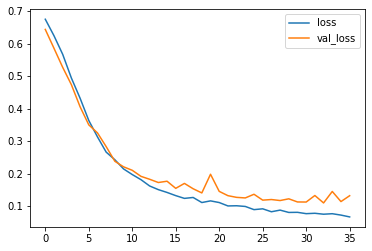

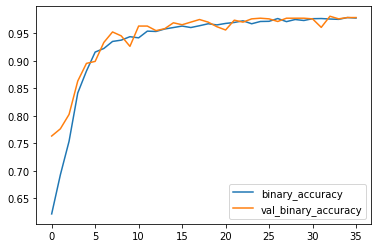

In [50]:
train_model(global_avg_model)

Model: "batch_normal_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 8)         32        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 16) 

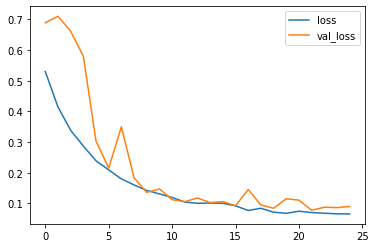

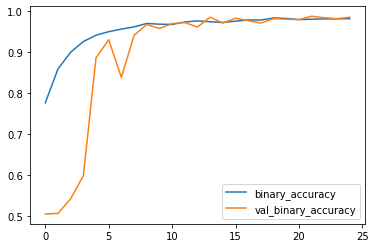

In [39]:
train_model(batch_normal_model)

Model: "deeper_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)               

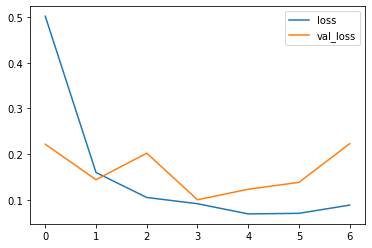

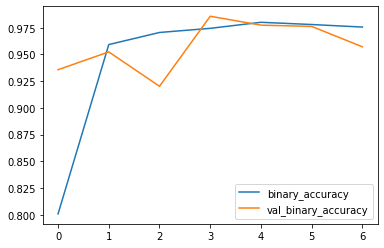

In [35]:
train_model(deeper_model)

Model: "wider_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 32769     
Total params: 37,857
Trainable params: 37,857
Non-trainable params: 0
___________________________________________________

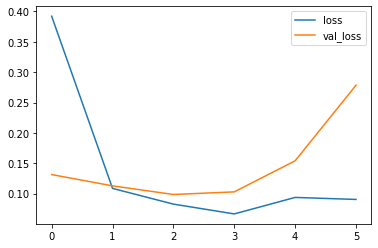

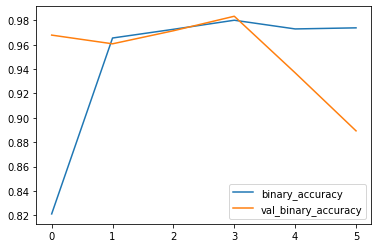

In [36]:
train_model(wider_model)

Model: "basic_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 16385     
Total params: 17,777
Trainable params: 17,777
Non-trainable params: 0
___________________________________________________

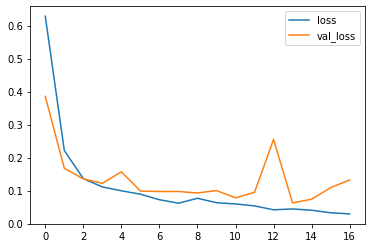

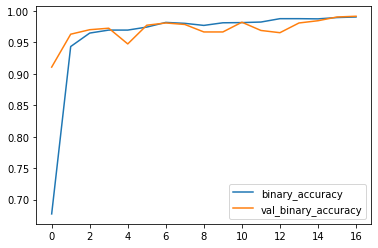

In [37]:
train_model(basic_model)

# Evaluate

In [41]:
def evaluate_model(model, test_data=test_data):
    results = model.evaluate(test_data, verbose=0)
    print("Model name: ", model.name)
    print("Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.3f}%".format(results[1]*100))
    print("-"*20)


def evaluate_model_cc(model, test_data=test_data):
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.3f}%".format(acc*100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int64))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE","POSITIVE"])
    
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n")
    print("-"*60)
    print(clr)

# Compare the models

Test Loss: 0.09046
Test Accuracy: 98.111%


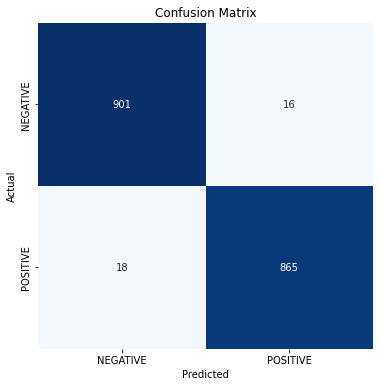

Classification Report:

------------------------------------------------------------
              precision    recall  f1-score   support

    NEGATIVE       0.98      0.98      0.98       917
    POSITIVE       0.98      0.98      0.98       883

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



In [43]:
evaluate_model_cc(batch_normal_model)

Test Loss: 0.10879
Test Accuracy: 96.722%


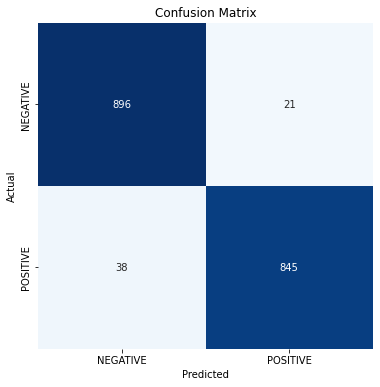

Classification Report:

------------------------------------------------------------
              precision    recall  f1-score   support

    NEGATIVE       0.96      0.98      0.97       917
    POSITIVE       0.98      0.96      0.97       883

    accuracy                           0.97      1800
   macro avg       0.97      0.97      0.97      1800
weighted avg       0.97      0.97      0.97      1800



In [51]:
evaluate_model_cc(global_avg_model)

Test Loss: 0.07140
Test Accuracy: 97.278%


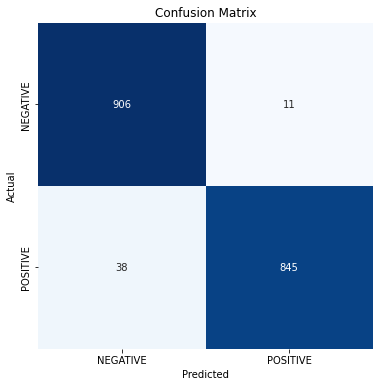

Classification Report:

------------------------------------------------------------
              precision    recall  f1-score   support

    NEGATIVE       0.96      0.99      0.97       917
    POSITIVE       0.99      0.96      0.97       883

    accuracy                           0.97      1800
   macro avg       0.97      0.97      0.97      1800
weighted avg       0.97      0.97      0.97      1800



In [56]:
evaluate_model_cc(basic_model)

# Checking Image Sample

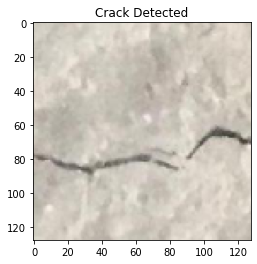

In [47]:
image = tf.keras.preprocessing.image.load_img("../input/surface-crack-detection/Positive/00040.jpg", target_size=(128,128))
input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
predictions = batch_normal_model.predict(input_arr)

plt.figure()
plt.imshow(image)

if(predictions[0]>=0.5):
    plt.title("Crack Detected")
else:
    plt.title("No Crack Detected")


# Showing loaded image in multiple vision

Visualizing Sample Image in Threshold, Canny & Contours



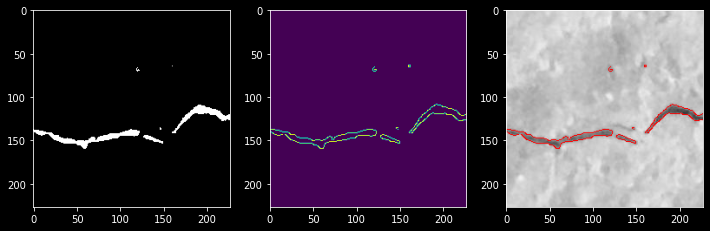

In [60]:
import cv2

plt.style.use("dark_background")
figure,axis = plt.subplots(nrows=1,ncols=3,figsize=(12,12))

Reading_Img = cv2.imread("../input/surface-crack-detection/Positive/00040.jpg", cv2.IMREAD_GRAYSCALE)
Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)

_,Threshold_Img = cv2.threshold(Reading_Img,150,255,cv2.THRESH_BINARY_INV)
Canny_Img = cv2.Canny(Threshold_Img,90,100)
contours,_ = cv2.findContours(Canny_Img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
Draw_Contours = cv2.drawContours(Reading_Img,contours,-1,(255,0,0),1)

axis[0].imshow(Threshold_Img)
axis[1].imshow(Canny_Img)
axis[2].imshow(Draw_Contours)

print("Visualizing Sample Image in Threshold, Canny & Contours\n=====================================================\n")

# Pick the best one

In [ ]:
# basic(8,16) + batch_normalization + global_avg_pooling = 98.111%

In [52]:
save_model(batch_normal_model)

batch_normal_model is saved
